In [46]:
import gc
gc.collect()

import os
from dotenv import load_dotenv

# Load the environment variables from the .env file
# Loads the HF_TOKEN into the environment, for accessing HuggingFace
load_dotenv()

# If your environment already has the HF_TOKEN key loaded, the above step can be ignored

True

In [47]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

import numpy
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os



In [48]:
# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

def clear_cache():
    gc.collect()
    if torch_device == 'cuda':
        torch.cuda.empty_cache()
    elif torch_device == 'mps':
        torch.mps.empty_cache()


# Loading the various components of the Stable-Diffusion pipeline from the pre-trained model

1. U-net
2. Text Encoder
3. VAE

In [49]:
#VAE
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

In [50]:
#Text Encoder
# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

In [51]:
#U-net
# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [52]:
#The noise scheduler to define the schedule of evolution associated with the diffusion process
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [53]:

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

# Initializing various parameters (including the text prompt)

In [54]:
#Basic parameters/settings for the process
prompt = ["A beautiful humming bird flapping its wings"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(42)   # Seed generator to create the inital latent noise
batch_size = 1

# Text Embedding
In the first step, we use the CLIP model to encode the text prompt into a vector in the latent space.
The core model works on a guidance principle. Hence, as a part of the embedding process, we also embed a vector of empty strings.

In [55]:
#setting up the text inputs

#Convert the prompt into an embedding
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]


#Convert empty string into an embedding
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

#Concatinating the two embeddings together
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])


#  Initializing the scheduler

In [56]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(scheduler,num_inference_steps)

#  Initializing the latents

In [57]:
# Standard Normal (mu = 0, sigma = 1) distributed initialization of the latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

#Scale the latents by the initial noise sigma (std. deviation of the gaussian noise)
latents = latents * scheduler.init_noise_sigma
print(latents.shape)

torch.Size([1, 4, 64, 64])


/var/folders/0f/214wbrld1gbdvhd6jrv5q2380000gn/T/ipykernel_11607/2257834883.py:3: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


# Stable Diffusion Loop

In [58]:
# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        
        # Scale the latents (preconditioning):
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual using the unet
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/30 [00:00<?, ?it/s]

# Decode the latents using the VAE

In [59]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Decoded image

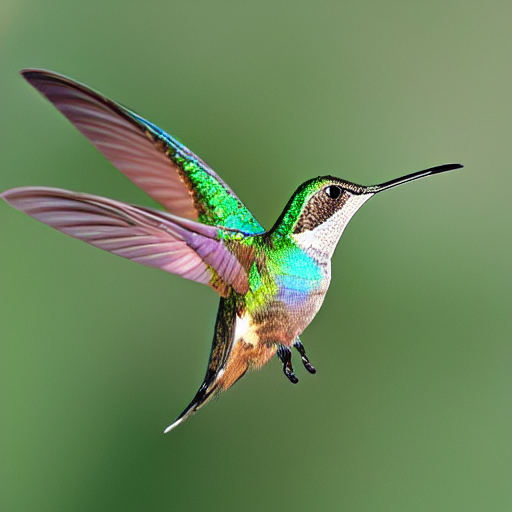

In [60]:
# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]